In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
# 读取数据
orders = pd.read_csv(r'H:\data_set\completion_volume_improvement\orders.csv', parse_dates=['request_time', 'accept_time', 'start_time', 'end_time'])
driver_activity = pd.read_csv(r'H:\data_set\completion_volume_improvement\driver_activity.csv', parse_dates=['date'])
user_requests = pd.read_csv(r'H:\data_set\completion_volume_improvement\user_requests.csv', parse_dates=['request_time'])
weather = pd.read_csv(r'H:\data_set\completion_volume_improvement\weather_holidays.csv', parse_dates=['date'])

In [3]:
# 添加时间字段
orders['date'] = orders['request_time'].dt.date
orders['hour'] = orders['request_time'].dt.hour
user_requests['date'] = user_requests['request_time'].dt.date
user_requests['hour'] = user_requests['request_time'].dt.hour

In [8]:
# 1. 指标拆解 
orders['is_completed'] = orders['status'] == '已完成'
daily_summary = orders.groupby('date').agg({
    'order_id': 'count',
    'is_completed': 'sum'
}).rename(columns={'order_id': '总订单量', 'is_completed': '完单量'})

# 匹配效率 = 完单量 / 请求量
daily_requests = user_requests.groupby('date').size().rename('请求量')
daily_summary = daily_summary.join(daily_requests)
daily_summary['匹配效率'] = daily_summary['完单量'] / daily_summary['请求量']


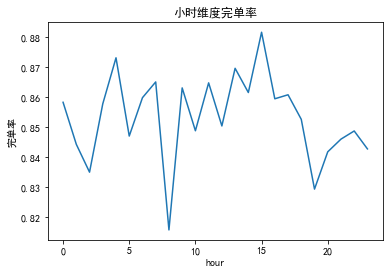

In [9]:
#  2. 多维分析 
# 时间维度
hourly_orders = orders.groupby('hour')['is_completed'].mean()
hourly_orders.plot(title='小时维度完单率', ylabel='完单率')
plt.show()

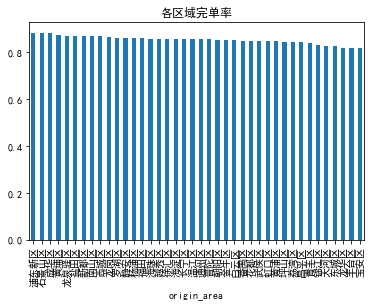

In [10]:
# 空间维度
area_completion = orders.groupby('origin_area')['is_completed'].mean().sort_values(ascending=False)
area_completion.plot(kind='bar', title='各区域完单率')
plt.show()

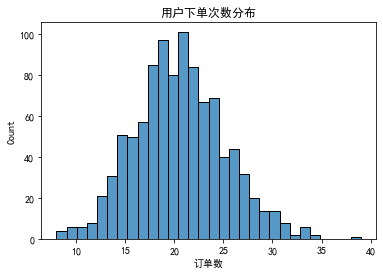

In [11]:
# 用户群体：每人平均下单数
user_order_counts = orders.groupby('user_id')['order_id'].count()
sns.histplot(user_order_counts, bins=30)
plt.title('用户下单次数分布')
plt.xlabel('订单数')
plt.show()

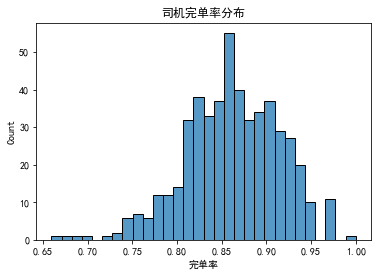

In [20]:
# 司机群体：完单率分布
driver_completion = driver_activity.copy().groupby('driver_id').agg({
'order_count':'sum',
'completed_order_count':'sum'    
})
driver_completion['完单率'] = driver_completion['completed_order_count'] / driver_completion['order_count']
sns.histplot(driver_completion['完单率'].dropna(), bins=30)
plt.title('司机完单率分布')
plt.xlabel('完单率')
plt.show()

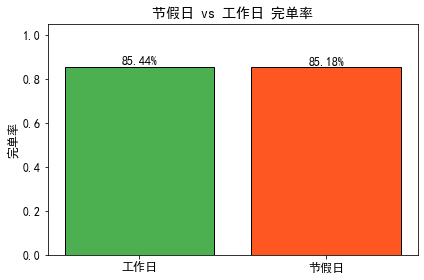

In [22]:
#  3. 因果推断初步 
# 节假日影响

# 确保日期格式一致
orders['date'] = pd.to_datetime(orders['date'])
weather['date'] = pd.to_datetime(weather['date'])

# 标记节假日
holiday_dates = weather[weather['is_holiday'] == 1]['date'].dt.date
orders['is_holiday'] = orders['date'].dt.date.isin(holiday_dates)

# 计算节假日与非节假日的完单率
holiday_completion = orders.groupby('is_holiday')['is_completed'].mean()

# 可视化设置
plt.figure(figsize=(6, 4))
colors = ['#4CAF50', '#FF5722']  # 工作日绿色，节假日橙色
bars = plt.bar(
    ['工作日', '节假日'],
    holiday_completion.values,
    color=colors,
    edgecolor='black'
)

# 添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontsize=12)

# 图表标题与轴标签
plt.title('节假日 vs 工作日 完单率', fontsize=14)
plt.ylabel('完单率', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

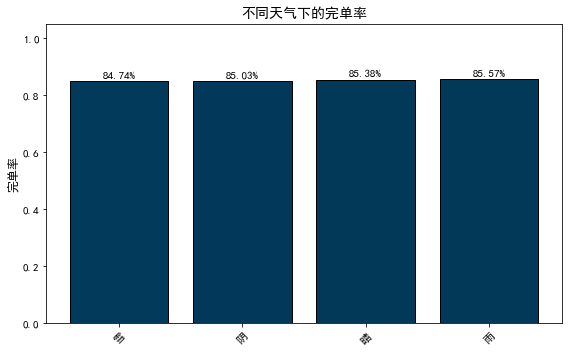

In [23]:
# 天气影响
import matplotlib.font_manager as fm

# 合并天气信息
orders['date'] = pd.to_datetime(orders['date'])
weather['date'] = pd.to_datetime(weather['date'])
orders = orders.merge(weather[['date', 'weather']], on='date', how='left')

# 计算不同天气的完单率
weather_completion = orders.groupby('weather')['is_completed'].mean().sort_values()

# 可视化设置
plt.figure(figsize=(8, 5))
colors = plt.cm.PuBu(weather_completion.values / weather_completion.max())  # 渐变色
bars = plt.bar(weather_completion.index, weather_completion.values, color=colors, edgecolor='black')

# 添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontsize=11)

# 图表标题与标签
plt.title('不同天气下的完单率', fontsize=14)
plt.ylabel('完单率', fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

宝安区 策略前完单率：78.36%
宝安区 策略后完单率：85.05%
变化幅度：6.70%


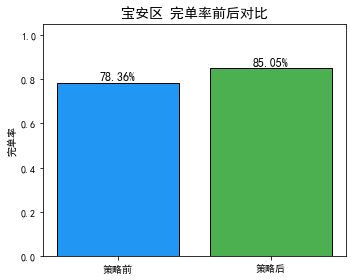

T检验 p值：0.0000 （显著差异）


In [27]:
# 4. A/B测试
from scipy.stats import ttest_ind

# 设置策略时间和城市
strategy_start_date = pd.to_datetime('2023-07-01')
target_city = '宝安区'

# 简化城市字段
orders['city'] = orders['origin_area']
orders['date'] = pd.to_datetime(orders['date'])

# 拆分策略前后数据
pre = orders[(orders['city'] == target_city) & (orders['date'] < strategy_start_date)]
post = orders[(orders['city'] == target_city) & (orders['date'] >= strategy_start_date)]

# 计算完单率
pre_rate = pre['is_completed'].mean()
post_rate = post['is_completed'].mean()

# 显示结果
print(f"{target_city} 策略前完单率：{pre_rate:.2%}")
print(f"{target_city} 策略后完单率：{post_rate:.2%}")
print(f"变化幅度：{(post_rate - pre_rate):.2%}")

# 可视化
plt.figure(figsize=(5, 4))
bars = plt.bar(['策略前', '策略后'], [pre_rate, post_rate], color=['#2196F3', '#4CAF50'], edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontsize=12)

plt.title(f"{target_city} 完单率前后对比", fontsize=14)
plt.ylabel("完单率")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# 可选：进行显著性检验（t检验）
t_stat, p_value = ttest_ind(pre['is_completed'], post['is_completed'], equal_var=False)
print(f"T检验 p值：{p_value:.4f} {'（显著差异）' if p_value < 0.05 else '（无显著差异）'}")